In [1]:
import cartopy

In [2]:
!pip3 install sklearn

In [3]:
!pip3 install pandas

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import scipy
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

In [5]:
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy

In [6]:
import cmocean

In [7]:
import sys
sys.path.append('/home/av555/iclr/')

In [8]:
from architectures import *
from trainer import *
from loaders import *
from models import *
from utils import *

In [9]:
from torch.distributions import Normal, MultivariateNormal

## Utils

In [10]:
def load_model(path, model):

    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    model.eval()
    return model, epoch, loss

In [11]:
def eval_model(model, val_loader):
    preds = []
    targets = []

    with torch.no_grad():
        for task in val_loader:
            task["dists"] = task["dists"][0,...]
            out = model(task)
            preds.append(out)
            targets.append(task["y_target"])

    #concat full arrays
    preds = torch.cat(preds, dim = 0)
    targets = torch.cat(targets, dim = 0)
    
    # Get distribution
    dist = Normal(preds[...,0], preds[...,1])
    s = dist.sample()

    #To cpu
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    s = s.cpu().numpy()

    return preds, targets, s

## Dataset

In [12]:
class UKHighResLoader(Dataset):
  
  def __init__(self, 
               data_dir, 
               device):

        super().__init__()

        self.DATA_DIR = data_dir
        self.device=device

        self.x_context = np.load(
            self.DATA_DIR+"context/x_context_coarse_final.npy")
        self.y_context = np.load(
            self.DATA_DIR+"context/y_context_coarse_final.npy", mmap_mode="r")[:8766,...]
        
        self.x_target = np.load(
            self.DATA_DIR+"spatial_samples/target_uk.npy")
        self.elev = np.load(
            self.DATA_DIR+"spatial_samples/elev_uk.npy")

        # Calculate dists and scale
        self.dists = get_dists(self.x_target, 
                                self.x_context[...,0], 
                                self.x_context[...,1])
        #x_scaler = MinMaxScaler().fit(self.dists.reshape(-1,1))
        #self.dists = x_scaler.transform(self.dists.reshape(-1,1)).reshape(self.dists.shape)

  def __len__(self):
        'Denotes the total number of samples'
        return self.y_context.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        y_context = torch.from_numpy(self.y_context[index,...]).float()

        dists = torch.from_numpy(self.dists).float()
        elev = torch.from_numpy(self.elev).float()
        x_target = torch.from_numpy(self.x_target).float()

        return {"y_context":y_context.to(self.device).unsqueeze(0),  
                "x_target":x_target.to(self.device).unsqueeze(0),
                "dists":dists.to(self.device),
                "elev":elev.to(self.device).unsqueeze(0)}

In [13]:
class GermanyHighResLoader(Dataset):
  
  def __init__(self, 
               data_dir, 
               device):

        super().__init__()

        self.DATA_DIR = data_dir
        self.device=device

        self.x_context = np.load(
            self.DATA_DIR+"context/x_context_coarse_final.npy")
        self.y_context = np.load(
            self.DATA_DIR+"context/y_context_coarse_final.npy", mmap_mode="r")[:8766,...]
        
        self.x_target = np.load(
            self.DATA_DIR+"spatial_samples/target_germany.npy")
        self.elev = np.load(
            self.DATA_DIR+"spatial_samples/elev_germany.npy")

        # Calculate dists and scale
        self.dists = get_dists(self.x_target, 
                                self.x_context[...,0], 
                                self.x_context[...,1])
        #x_scaler = MinMaxScaler().fit(self.dists.reshape(-1,1))
        #self.dists = x_scaler.transform(self.dists.reshape(-1,1)).reshape(self.dists.shape)

  def __len__(self):
        'Denotes the total number of samples'
        return self.y_context.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        y_context = torch.from_numpy(self.y_context[index,...]).float()

        dists = torch.from_numpy(self.dists).float()
        elev = torch.from_numpy(self.elev).float()
        x_target = torch.from_numpy(self.x_target).float()

        return {"y_context":y_context.to(self.device).unsqueeze(0),  
                "x_target":x_target.to(self.device).unsqueeze(0),
                "dists":dists.to(self.device),
                "elev":elev.to(self.device).unsqueeze(0)}

## Load model and plot

In [22]:
import warnings
warnings.filterwarnings("always")

import warnings
warnings.filterwarnings("ignore")

In [23]:
use_cpu = True
device = torch.device('cpu') if use_cpu else torch.device('cuda')

In [24]:
def plot_panel(ax, title, left=False, top=False, right=False):
    ax.coastlines()
    ax.gridlines()
    ax.set_extent([-5.2, 1, 49.8, 54])
    ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    gl = ax.gridlines()
    #gl.xlabels_top = False
    if left:
        gl.ylabels_left = True
    if right:
        gl.ylabels_right = True
    if top:
        gl.xlabels_top = True
    
    ax.set_title(title)
    

In [25]:
def get_samples(model, val_ds, ind):
    test = val_ds.__getitem__(ind)
    out = model(test)

    # Get distribution
    dist = Normal(out[...,0], out[...,1])
    s1 = dist.sample().cpu().numpy().reshape(96,76)
    s2 = dist.sample().cpu().numpy().reshape(96,76)
    s3 = dist.sample().cpu().numpy().reshape(96,76)

    lon_target = val_ds.x_target[...,0].reshape(96,76)
    lat_target = val_ds.x_target[...,1].reshape(96,76)
    pred_mean = out[0,:,0].detach().numpy().reshape(96,76)
    pred_sigma = out[0,:,1].detach().numpy().reshape(96,76)
    
    # Reanalysis
    a = pickle.load(open("/home/av555/iclr/data/Y_context_t.pkl", "rb"))
    context = val_ds.y_context
    x_context = val_ds.x_context

    tt = context[ind,...].transpose(1,2,0).reshape(-1,25)
    reanalysis = a.inverse_transform(tt[:,6:]).reshape(32,19,19)
    reanalysis = reanalysis[:,:,1]-273.15
    x_context = val_ds.x_context

    return {"reanalysis":reanalysis,
            "x_context":x_context,
            "lon_target":lon_target,
            "lat_target":lat_target,
            "pred_mean":pred_mean,
            "pred_sigma":pred_sigma,
            "s1":s1,
            "s2":s2,
            "s3":s3}

In [26]:
def get_samples_convGNP(model, val_ds, ind):
    test = val_ds.__getitem__(ind)
    out = model(test).double()
    x_context = val_ds.x_context

    # Get distribution
    mean = out[:, :, 0]
    noise = out[:, :, 1]
    noise = torch.exp(noise)[:, :, None]
    feat = out[:, :, 2:-1]
    v = out[:,:,-1:]

    #compute the covariance
    mean = out[:, :, 0]
    noise = out[:, :, 1]
    #noise = torch.exp(noise)[:, :, None]
    feat = out[:, :, 2:]

    cov = torch.einsum('bnc, bmc -> bnm', feat, feat) / feat.shape[-1]
    cov = cov + torch.eye(cov.shape[1]).double()[None, :, :]*1e-4 #* (1e-6 + noise)
    
    print(cov.shape)
    print(mean.shape)
    p = plt.imshow(cov[0,...].detach().numpy(), vmax=1)
    plt.colorbar(p)
    plt.show()
    

    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    
    s1 = dist.sample().cpu().numpy().reshape(96,76)
    plt.imshow(s1)
    plt.show()
    s2 = dist.sample().cpu().numpy().reshape(96,76)
    s3 = dist.sample().cpu().numpy().reshape(96,76)

    lon_target = val_ds.x_target[...,0].reshape(96,76)
    lat_target = val_ds.x_target[...,1].reshape(96,76)
    pred_mean = out[0,:,0].detach().numpy().reshape(96,76)
    pred_sigma = np.sqrt(torch.diagonal(cov).detach().numpy().reshape(96,76))
    
    # Reanalysis
    a = pickle.load(open("/home/av555/iclr/data/Y_context_t.pkl", "rb"))
    context = val_ds.y_context
    x_context = val_ds.x_context

    tt = context[ind,...].transpose(1,2,0).reshape(-1,25)
    reanalysis = a.inverse_transform(tt[:,6:]).reshape(32,19,19)
    reanalysis = reanalysis[:,:,1]-273.15

    return {"reanalysis":reanalysis,
            "x_context":x_context,
            "lon_target":lon_target,
            "lat_target":lat_target,
            "pred_mean":pred_mean,
            "pred_sigma":pred_sigma,
            "s1":s1,
            "s2":s2,
            "s3":s3}

In [27]:
def get_samples_convGNP_kvv(model, val_ds, ind):
    test = val_ds.__getitem__(ind)
    out = model(test).double()
    x_context = val_ds.x_context
    
    mean = out[:, :, 0]
    noise = out[:, :, 1]
    noise = torch.exp(noise)[:, :, None]
    feat = out[:, :, 2:-1]
    v = out[:,:,-1:]

    #compute the covariance
    vv = torch.matmul(v, torch.transpose(v, dim0=-2, dim1=-1)) 
    scales = model.kernel_fn(model.kernel_sigma)
    cov = rbf_kernel(feat, scales)
    cov = cov * vv
    cov = cov + torch.eye(cov.shape[1]).double()[None, :, :]*1e-6

    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    
    
    s1 = dist.sample().cpu().numpy().reshape(96,76)
    plt.imshow(s1)
    plt.show()
    s2 = dist.sample().cpu().numpy().reshape(96,76)
    s3 = dist.sample().cpu().numpy().reshape(96,76)

    lon_target = val_ds.x_target[...,0].reshape(96,76)
    lat_target = val_ds.x_target[...,1].reshape(96,76)
    pred_mean = out[0,:,0].detach().numpy().reshape(96,76)
    #pred_sigma = out[0,:,1].detach().numpy().reshape(96,76)
    pred_sigma = torch.diagonal(cov).detach().numpy().reshape(96,76)
    
    # Reanalysis
    a = pickle.load(open("/home/av555/iclr/data/Y_context_t.pkl", "rb"))
    context = val_ds.y_context
    x_context = val_ds.x_context

    tt = context[ind,...].transpose(1,2,0).reshape(-1,25)
    reanalysis = a.inverse_transform(tt[:,6:]).reshape(32,19,19)
    reanalysis = reanalysis[:,:,1]-273.15
    
    return {"reanalysis":reanalysis,
            "x_context":x_context,
            "lon_target":lon_target,
            "lat_target":lat_target,
            "pred_mean":pred_mean,
            "pred_sigma":pred_sigma,
            "s1":s1,
            "s2":s2,
            "s3":s3}

In [28]:
def plot_figure(reanalysis, x_context, lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3):
    
    fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2, 3, subplot_kw={'projection': crs.PlateCarree()}, figsize=(13,9))
    
    plot_panel(ax1, "ERA-I Reanalysis", top=True, left=True)
    p = ax1.pcolormesh(x_context[...,0], x_context[...,1], reanalysis, cmap="seismic", vmin=-25, vmax=25) #5) #, vmin=-5, vmax=15) #, transform=rotated_pole)
    c = plt.colorbar(p, orientation="horizontal", ax=ax1, pad=0.01)
    c.set_label("Maximum temperature (C)")
    
    plot_panel(ax2, "Predicted $\mu$", top=True)
    p = ax2.pcolormesh(lon_target, lat_target, pred_mean, cmap="seismic", vmin=-25, vmax=25) #, transform=rotated_pole)
    c = plt.colorbar(p, orientation="horizontal", ax=ax2, pad=0.01)
    c.set_label("Maximum temperature (C)")
    
    plot_panel(ax3, "Predicted $\sigma$", top=True, right=True)
    p = ax3.pcolormesh(lon_target, lat_target, pred_sigma, cmap="magma", vmin=0, vmax=3) #, transform=rotated_pole)
    c = plt.colorbar(p, orientation="horizontal", ax=ax3, pad=0.01)
    c.set_label("Maximum temperature (C)")
    
    plot_panel(ax4, "Sample 1", left=True)
    p = ax4.pcolormesh(lon_target, lat_target, s1, cmap="seismic", vmin=-25, vmax=25) #, transform=rotated_pole)
    c = plt.colorbar(p, orientation="horizontal", ax=ax4, pad=0.01)
    c.set_label("Maximum temperature (C)")
    
    plot_panel(ax5, "Sample 2", left=True)
    p = ax5.pcolormesh(lon_target, lat_target, s2, cmap="seismic", vmin=-25, vmax=25) #, transform=rotated_pole)
    c = plt.colorbar(p, orientation="horizontal", ax=ax5, pad=0.01)
    c.set_label("Maximum temperature (C)")
    
    plot_panel(ax6, "Sample 3", left=True)
    p = ax6.pcolormesh(lon_target, lat_target, s3, cmap="seismic", vmin=-25, vmax=25) #, transform=rotated_pole)
    c = plt.colorbar(p, orientation="horizontal", ax=ax6, pad=0.01)
    c.set_label("Maximum temperature (C)")
    
    plt.show()
    
    

In [29]:
#######n IND
ind = 12

# data
val_ds = UKHighResLoader("/home/av555/iclr/data/", device=device)
val_loader = DataLoader(
    val_ds, batch_size = 16, shuffle = False)

In [45]:


# 

## convCNP

In [46]:
# ConvCNP

convcnp_path = "/home/av555/iclr/exps_no_distance_scaling/convCNP_value_all/epoch_491"
concnp_model = convCNP(
    in_channels=25)

concnp_model, convcnp_epoch, convcnp_loss = load_model(convcnp_path, concnp_model)

In [47]:
lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3 = get_samples(concnp_model, val_ds, ind)

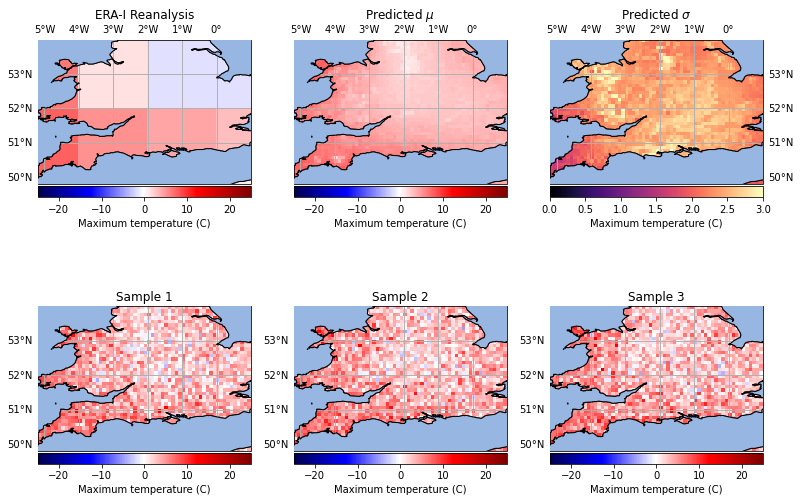

In [48]:
plot_figure(reanalysis, x_context, lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3)

## convGNP linear

In [49]:
# ConvGNP

convcnp_path = "/home/av555/iclr/exps_no_distance_scaling/convGNP_linear_value_all/epoch_488"
concnp_model = convGNPLinear()

concnp_model, convcnp_epoch, convcnp_loss = load_model(convcnp_path, concnp_model)

lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3 = get_samples_convGNP(concnp_model, val_ds, ind)

torch.Size([1, 2838, 2838])
torch.Size([1, 2838])


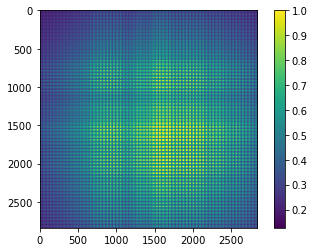

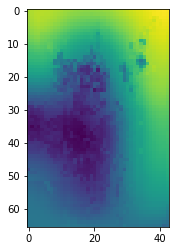

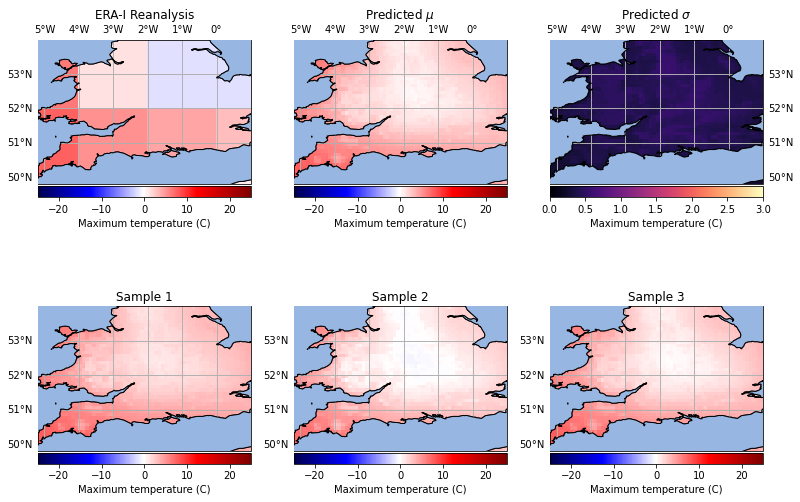

In [51]:
plot_figure(reanalysis, x_context, lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3)

## convGNP kvv

In [52]:
# ConvGNP

convcnp_path = "/home/av555/iclr/exps_no_distance_scaling/convGNP_kvv_value_all/epoch_401"
concnp_model = convGNPKvv()

concnp_model, convcnp_epoch, convcnp_loss = load_model(convcnp_path, concnp_model)

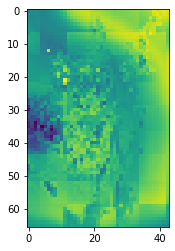

In [53]:
lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3 = get_samples_convGNP_kvv(concnp_model, val_ds, ind)

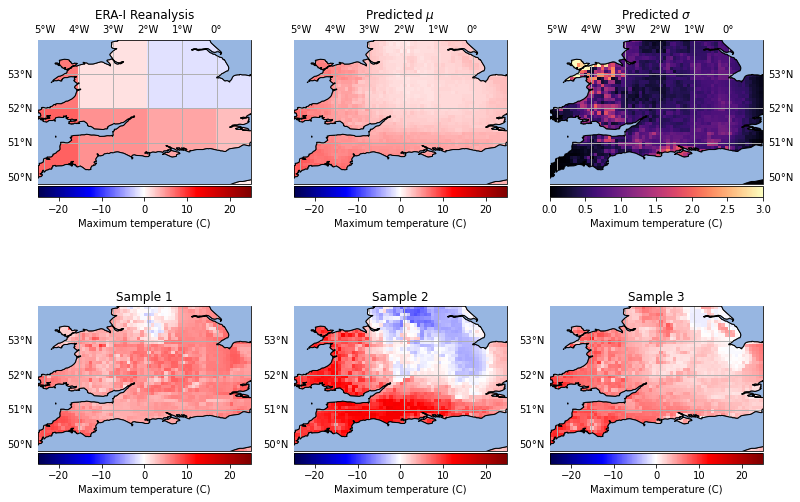

In [54]:
plot_figure(reanalysis, x_context, lon_target, lat_target, pred_mean, pred_sigma, s1, s2, s3)

## Plot giant figure

In [30]:
def plot_gpanel(ax, title=False, title_text=None, left=False, top=False, right=False, ylabel=None):
    ax.coastlines()
    ax.gridlines()
    #ax.set_extent([-5.2, 1, 49.8, 54])
    ax.set_extent([6.25, 15.75, 47.25, 54.75])
    ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='k')
    ax.add_feature(cfeature.BORDERS.with_scale('10m'))
    gl = ax.gridlines()
    
    ax.set_ylabel(ylabel)
    plt.ylabel(ylabel)
    
    #gl.xlabels_top = False
    if left:
        gl.ylabels_left = True
    if right:
        gl.ylabels_right = True
    if top:
        gl.xlabels_top = True
    if title:
        ax.set_title(title_text)
        
    

In [31]:
def plot_grow(ax_list, model_dict, title=False, lower=False, top=False, ylabel=None):
    plot_gpanel(ax_list[0], title=title, title_text="ERA-I Reanalysis", top=top, left=True, ylabel=ylabel)
    vmin = -15
    vmax = 15
    
    p = ax_list[0].pcolormesh(model_dict["x_context"][...,0], 
                              model_dict["x_context"][...,1], 
                              model_dict["reanalysis"], 
                              cmap="seismic", 
                              vmin=vmin, vmax=vmax) #5) #, vmin=-5, vmax=15) #, transform=rotated_pole)
    
    
    if lower:
        c = plt.colorbar(p, orientation="horizontal", ax=ax_list[0], pad=0.1)
        c.set_label("Maximum temperature (C)")
    
    plot_gpanel(ax_list[1], title=title, title_text="Predicted $\mu$", top=top)
    p = ax_list[1].pcolormesh(model_dict["lon_target"], 
                              model_dict["lat_target"], 
                              model_dict["pred_mean"], 
                              cmap="seismic", 
                              vmin=vmin, vmax=vmax) #, transform=rotated_pole)
    if lower:
        c = plt.colorbar(p, orientation="horizontal", ax=ax_list[1], pad=0.1)
        c.set_label("Maximum temperature (C)")
    
    plot_gpanel(ax_list[2], title=title, title_text="Sample 1", top=top)
    p = ax_list[2].pcolormesh(model_dict["lon_target"], 
                              model_dict["lat_target"], 
                              model_dict["s1"],
                              cmap="seismic", 
                              vmin=vmin, vmax=vmax) #, transform=rotated_pole)
    if lower:
        c = plt.colorbar(p, orientation="horizontal", ax=ax_list[2], pad=0.1)
        c.set_label("Maximum temperature (C)")
    
    plot_gpanel(ax_list[3], title=title, title_text="Sample 2", top=top)
    p = ax_list[3].pcolormesh(model_dict["lon_target"], 
                              model_dict["lat_target"], 
                              model_dict["s2"],
                              cmap="seismic", 
                              vmin=vmin, vmax=vmax) #, transform=rotated_pole)
    if lower:
        c = plt.colorbar(p, orientation="horizontal", ax=ax_list[3], pad=0.1)
        c.set_label("Maximum temperature (C)")
    
    plot_gpanel(ax_list[4], title=title, title_text="Sample 3", right=True, top=top)
    p = ax_list[4].pcolormesh(model_dict["lon_target"], 
                              model_dict["lat_target"], 
                              model_dict["s3"], 
                              cmap="seismic", 
                              vmin=vmin, vmax=vmax) #, transform=rotated_pole)
    if lower:
        c = plt.colorbar(p, orientation="horizontal", ax=ax_list[4], pad=0.1)
        c.set_label("Maximum temperature (C)")
    

In [32]:
def plot_gfigure(convcnp_dict, convgnp_linear_dict, convgnp_kvv_dict):
    
    fig, (r1, r2, r3) = plt.subplots(
        3, 5, subplot_kw={'projection': crs.PlateCarree()}, figsize=(15,7))
    
    # convCNP
    plot_grow(r1, convcnp_dict, title=True, top=True, ylabel="ConvGNP (meanfield)")
    
    # convGNP linear
    plot_grow(r2, convgnp_linear_dict, title=False, ylabel="ConvGNP (linear)")
    
    # convGNP kvv
    plot_grow(r3, convgnp_kvv_dict, title=False, lower=False, ylabel="ConvGNP (kvv)")
    
    plt.tight_layout()

    plt.savefig("/home/av555/iclr/test_figure.png", dpi=150)
    

In [33]:
#######n IND
ind = 366

# data
val_ds = GermanyHighResLoader("/home/av555/iclr/data/", device=device)
val_loader = DataLoader(
    val_ds, batch_size = 2, shuffle = False)

In [34]:
# ConvCNP

convcnp_path = "/home/av555/iclr/exps_no_distance_scaling/convCNP_value_all/epoch_491"
concnp_model = convCNP(
    in_channels=25)

convcnp_model, _, _ = load_model(convcnp_path, concnp_model)
convcnp_dict = get_samples(convcnp_model, val_ds, ind)

torch.Size([1, 7296, 7296])
torch.Size([1, 7296])


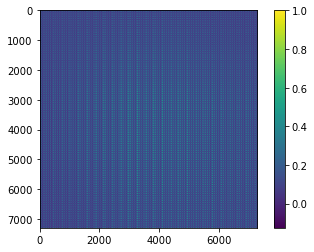

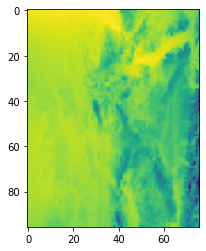

In [35]:
# ConvGNP

convgnp_linear_path = "/home/av555/iclr/exps_no_distance_scaling/convGNP_linear_value_all/epoch_488"
convgnp_linear_model = convGNPLinear()

convgnp_linear_model, _, _ = load_model(convgnp_linear_path, convgnp_linear_model)

convgnp_linear_dict = get_samples_convGNP(convgnp_linear_model, val_ds, ind)

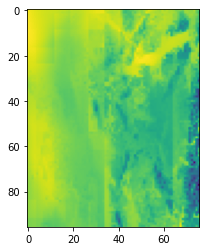

In [36]:
# ConvGNP

convgnp_kvv_path = "/home/av555/iclr/exps_no_distance_scaling/convGNP_kvv_value_all/epoch_401"
convgnp_kvv_model = convGNPKvv()

convgnp_kvv_model, _, _ = load_model(convgnp_kvv_path, convgnp_kvv_model)

convgnp_kvv_dict = get_samples_convGNP_kvv(convgnp_kvv_model, val_ds, ind)

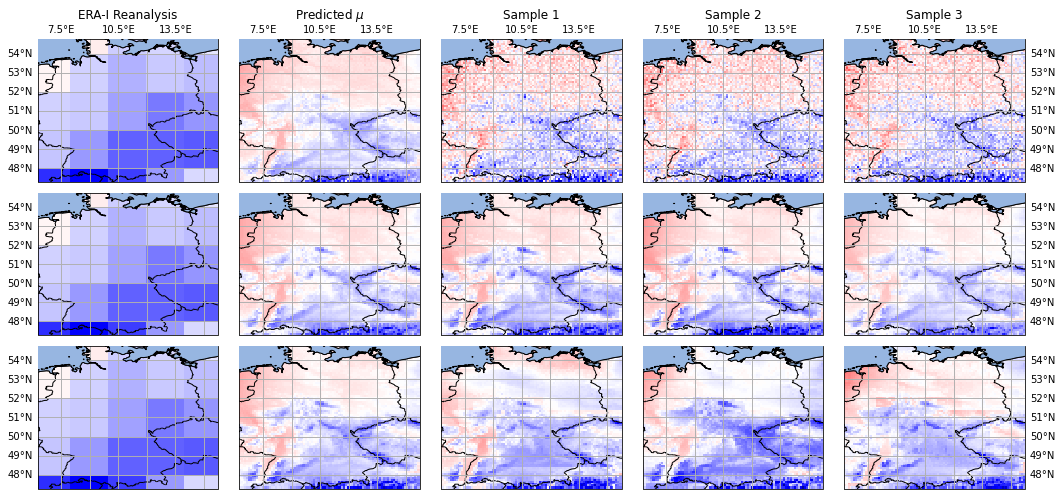

In [37]:
plot_gfigure(convcnp_dict, convgnp_linear_dict, convgnp_kvv_dict)

In [38]:
import pickle

with open('/home/av555/iclr/convCNP.pkl', 'wb') as handle:
    pickle.dump(convcnp_dict, handle)


In [39]:
with open('/home/av555/iclr/convGNP_linear.pkl', 'wb') as handle:
    pickle.dump(convgnp_linear_dict, handle)

In [40]:
with open('/home/av555/iclr/convGNP_kvv.pkl', 'wb') as handle:
    pickle.dump(convgnp_kvv_dict, handle)

In [69]:
import xarray as xr

In [70]:
gt = xr.open_dataset("/home/av555/iclr/data/spatial_samples/germany_era5_land.nc")

In [71]:
gt_daily = gt.resample(time="1D").max()


In [44]:
gt_daily["t2m"] = gt_daily.t2m-273.15

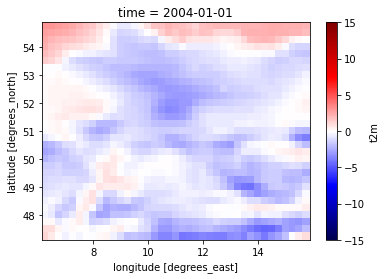

In [53]:
gt_daily.t2m.isel(time=0).plot(vmin=-15, vmax=15, cmap="seismic")

In [46]:
gt_daily

<xarray.Dataset>
Dimensions:    (time: 10, longitude: 39, latitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2004-01-01 2004-01-02 ... 2004-01-10
  * longitude  (longitude) float32 6.25 6.5 6.75 7.0 ... 15.0 15.25 15.5 15.75
  * latitude   (latitude) float32 54.75 54.5 54.25 54.0 ... 47.75 47.5 47.25
Data variables:
    t2m        (time, latitude, longitude) float32 3.159 3.049 ... 0.8297 1.512